In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.datasets import load_sample_image

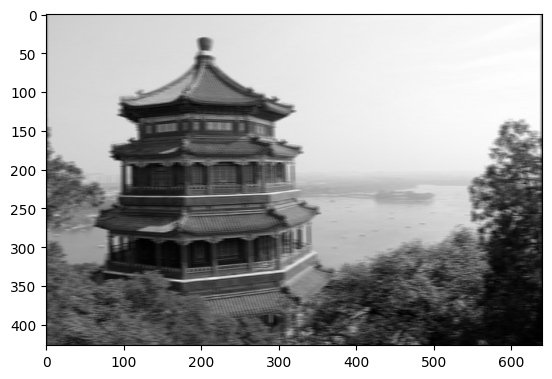

In [5]:
import matplotlib.pyplot as plt

china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

# Создаем два фильтра
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1 # вертикальная линия
filters[3, :, :, 1] = 1 # горизонтальная линия
outputs = tf.nn.conv2d(images, filters, strides=1, padding='SAME')

plt.imshow(outputs[0, :, :, 1], cmap='gray') # нарисовать 2 карту признаков 1-го изобр
plt.show()

Слой Pooling-а

In [ ]:
max_pool = keras.layers.MaxPool2D(pool_size=2) # AvgPool2D

In [ ]:
output = tf.nn.max_pool(images,
                        ksize=(1, 1, 1, 3),
                        strides=(1, 1, 1, 3),
                        padding="VALID")

In [ ]:
# Добавление в качестве слоя
deth_pool = keras.layers.Lambda(
    lambda X: tf.nn.max_pool(X, ksize=(1, 1, 1, 3),
                        strides=(1, 1, 1, 3),
                        padding="VALID")
)

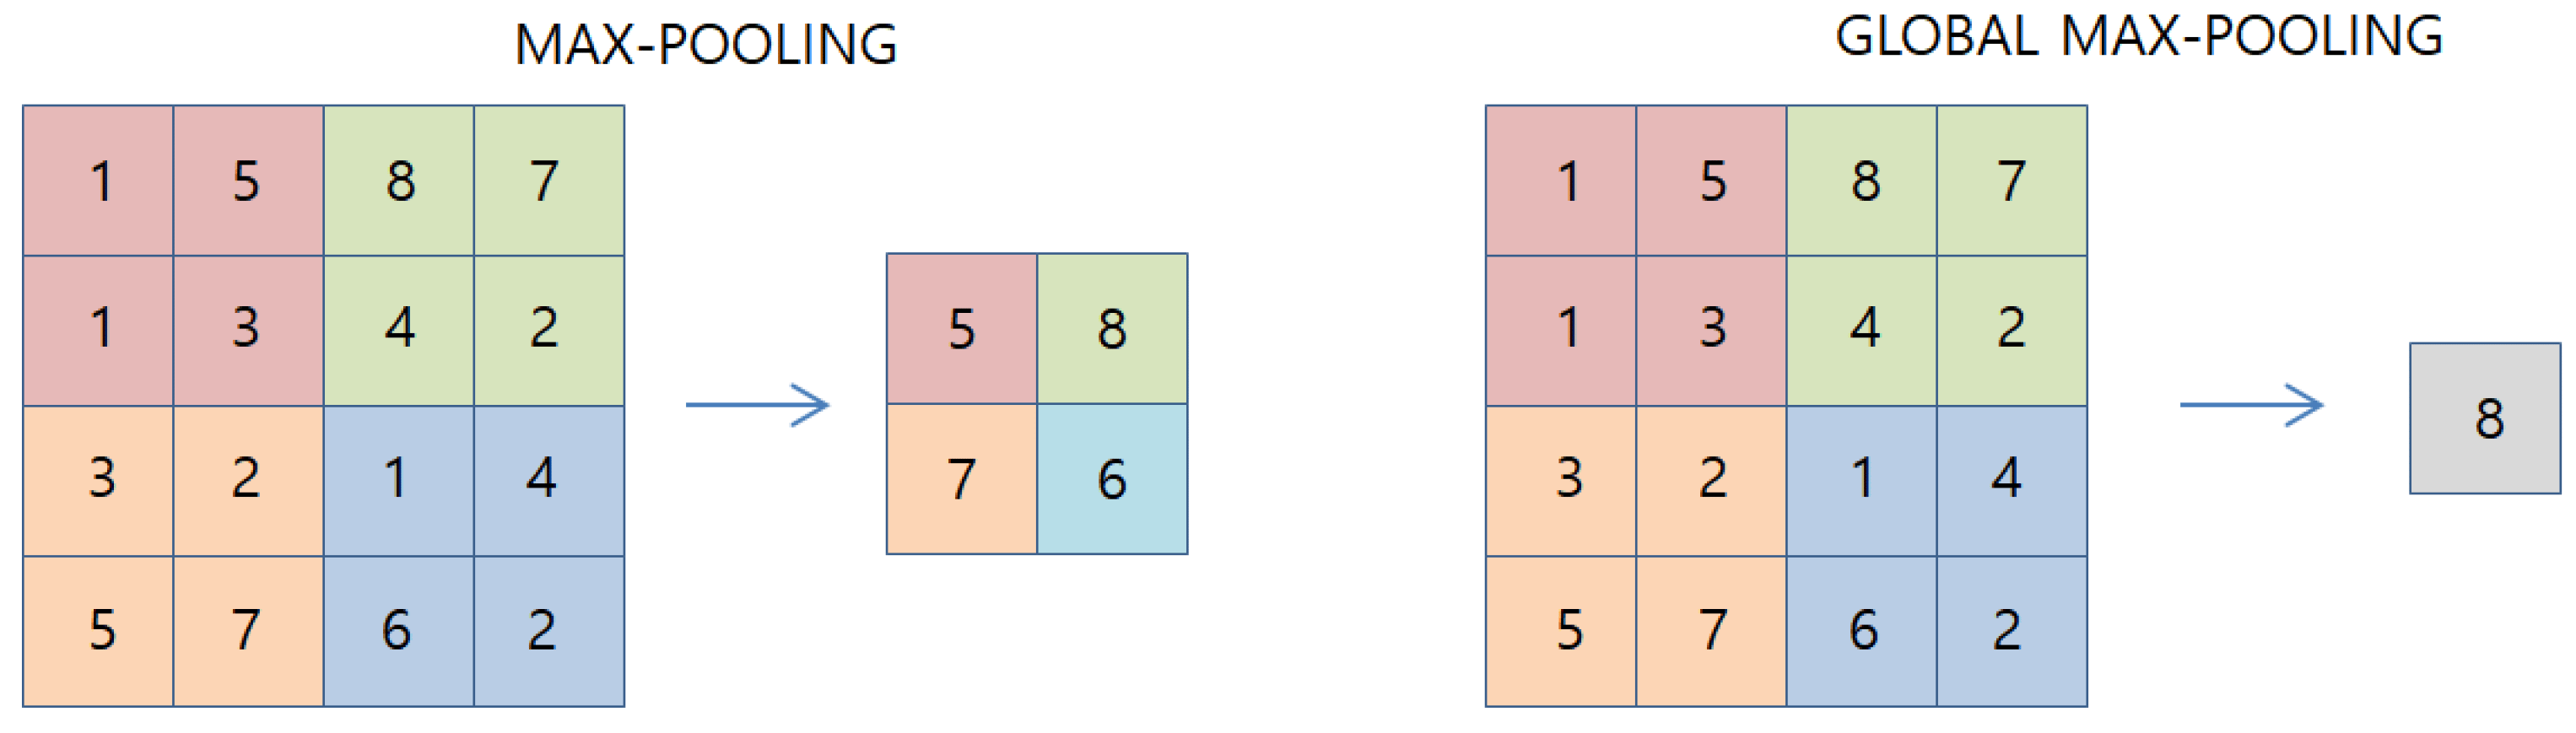

In [ ]:
global_avg_pool = keras.layers.GlobalAvgPool2D()
global_avg_pool = keras.layers.Lambda(lambda X: tf.reduce_mean(X, axis=[1, 2]))

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(64, 7, activation="relu", padding="SAME", input_shape=[28, 28, 1]), # 64 фильтра 7x7
    MaxPooling2D(2),
    Conv2D(128, 3, activation="relu", padding="SAME"),
    Conv2D(128, 3, activation="relu", padding="SAME"),
    MaxPooling2D(2),
    Conv2D(256, 3, activation="relu", padding="SAME"),
    Conv2D(256, 3, activation="relu", padding="SAME"),
    MaxPooling2D(2),
    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(64, activation="relu"),
    Dropout(0.5),
    Dense(10, activation="softmax"),
])

# ResNet

In [3]:
class ResidualUnit(keras.layers.Layer):
  def __init__(self, filters, strides=1, activation="relu", **kwargs):
    super().__init__(**kwargs)
    self.activation = keras.activations.get(activation)
    self.main_layers = [
        keras.layers.Conv2D(filters, 3, strides=strides, padding="SAME", use_bias=False),
        keras.layers.BatchNormalization(),
        self.activation,
        keras.layers.Conv2D(filters, 3, strides=1, padding="SAME", use_bias=False),
        keras.BatchNormalization()
    ]
    self.skip_layers = []
    if strides > 1:
      self.skip_layers = [
          keras.layers.Conv2D(filters, 3, strides=strides, padding="SAME", use_bias=False),
          keras.BatchNormalization()
      ]

  def call(self, inputs):
    Z = inputs
    for layer in self.main_layers:
      Z = layer(Z)
    skip_Z = inputs
    for layer in self.skip_layers:
      skip_Z = layer(skip_Z)
    return self.activation(Z + skip_Z)

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(64, 7, strides=2, input_shape=[224, 224, 3], padding="SAME", use_bias=False))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))

prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3: # изменение фильтров
  strides = 1 if filters == prev_filters else 2
  model.add(ResidualUnit(filters, strides=strides))
  prev_filters = filters

model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

# Transfer Learning

ResNet50

In [4]:
model = keras.applications.resnet50.ResNet50(weights="imagenet")

102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [6]:
images_resized = tf.image.resize(images, [224, 224]) # crop_and_resize

In [7]:
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)

Y_proba = model.predict(inputs)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


In [8]:
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
  print("Image #{}".format(image_index))
  for class_id, name, y_proba in top_K[image_index]:
    print("{} - {:12s} {:.2f}%".format(class_id, name, y_proba * 100))
  print()

35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Image #0
n02825657 - bell_cote    82.35%
n03877845 - palace       6.75%
n03781244 - monastery    4.19%

Image #1
n03530642 - honeycomb    49.81%
n13040303 - stinkhorn    33.96%
n02206856 - bee          4.35%



Доступные модели:

1.   ResNet
2.   GoogLeNet (Inception-v3, Xception)
3.   VGGNet
4.   MobileNet (V2) - легковесные, для мобильных приложений

  ...

Использование заранее обученных моделей для обучения передачей заний

In [10]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True) # with_info=True выводит информацию о датасете
dataset_size = info.splits["train"].num_examples
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [17]:
datasets, info = tfds.load(
    'tf_flowers',
    split=['train[:10%]', 'train[10%:25%]', 'train[25%:]'],
    with_info=True,
    as_supervised=True
)

test_set, valid_set, train_set = datasets

In [21]:
def preprocess(image, label):
  resized_image = tf.image.resize(image, [224, 224])
  final_image = keras.applications.xception.preprocess_input(resized_image)
  return final_image, label

In [22]:
batch_size = 32
train_set = train_set.shuffle(1000)
train_set = train_set.map(preprocess).batch(batch_size).prefetch(1)
valid_set = valid_set.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set.map(preprocess).batch(batch_size).prefetch(1)

**tf.image.random_crop()**

**tf.image.random_flip_left_right()**

In [26]:
base_model = keras.applications.xception.Xception(weights="imagenet", include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.Model(inputs=base_model.input, outputs=output)

In [27]:
for layer in base_model.layers:
  layer.trainable = False

In [32]:
optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, epochs=5, validation_data=valid_set)

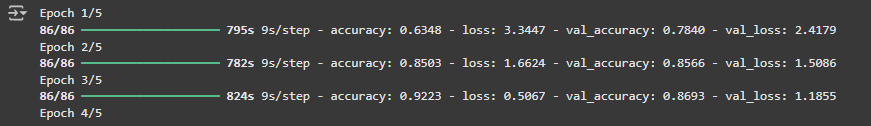

In [34]:
for layer in base_model.layers:
  layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, decay=0.001) # понижен lr и decay
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, epochs=2, validation_data=valid_set)

# Классификация и установление местанахождения | Регрессия

In [35]:
base_model = keras.applications.xception.Xception(weights="imagenet", include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = keras.layers.Dense(n_classes, activation="softmax")(avg)
loc_output = keras.layers.Dense(4)(avg)
model = keras.Model(inputs=base_model.input, outputs=[class_output, loc_output])
model.compile(loss=["sparse_categorical_crossentropy", "mse"],
              loss_weights=[0.8, 0.2],
              optimizer=optimizer,
              metrics=["accuracy"])